### Importing the libraries 

In [27]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import warnings
from PIL import Image, ImageEnhance
import cv2
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
import random
import shutil
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from transformers import AutoModel
from tensorflow.keras.mixed_precision import set_global_policy
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0

In [2]:
import transformers
print(transformers.__version__)

4.49.0


### Reading both our train and test data & EDA

In [5]:
# Define dataset paths
train_dir = r"C:\Users\S P E C T R E\Desktop\Personal Projects\Melanoma-Cancer-Image-Analysis\dataset\train"
test_dir = r"C:\Users\S P E C T R E\Desktop\Personal Projects\Melanoma-Cancer-Image-Analysis\dataset\test"

# Get class names (benign & malignant)
categories = os.listdir(train_dir)
categories

['Benign', 'Malignant']

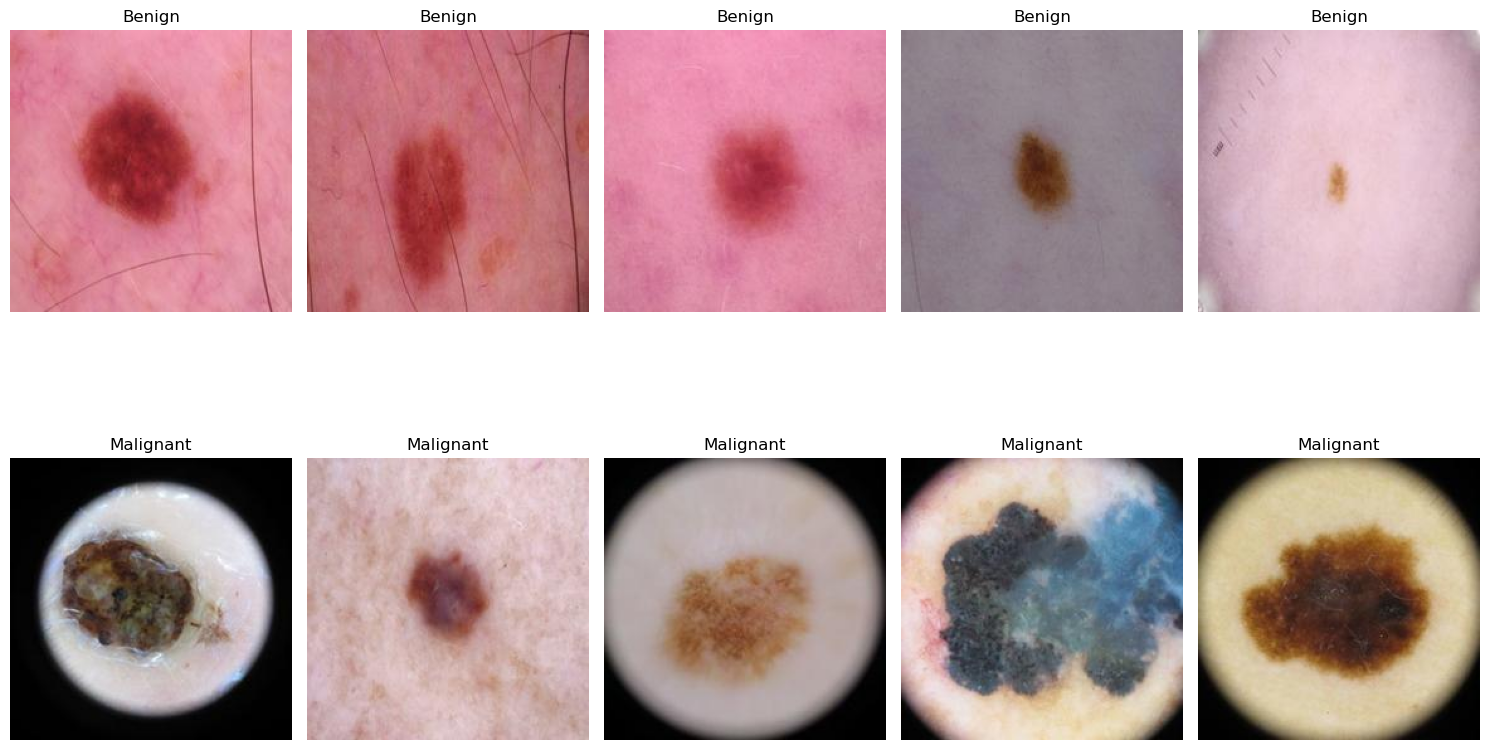

In [6]:
# Function to display sample images for each category
def display_sample_images(data_dir, categories, num_samples=5):
    plt.figure(figsize=(15, 10))
    
    for i, category in enumerate(categories):
        category_path = os.path.join(data_dir, category)
        images = os.listdir(category_path)
        
        for j in range(num_samples):
            sample_image = random.choice(images)
            img_path = os.path.join(category_path, sample_image)
            
            # Read and display image
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            
            plt.subplot(len(categories), num_samples, i * num_samples + j + 1)
            plt.imshow(img)
            plt.title(category)
            plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Display sample images
display_sample_images(train_dir, categories)

Looking at these benign samples, we can already observe some challenges in the dataset;

Variability in Skin Tone & Lighting

The benign image has a reddish tone, while the malignant image has a neutral skin tone.
This variation might affect model performance if not normalized properly.
Presence of Artifacts

The malignant image contains hairs and dark marks that are unrelated to the lesion.
These could introduce noise and cause the model to focus on irrelevant features.
Uneven Focus & Resolution

The benign image is sharper, while the malignant image appears a bit blurry.
This might affect the feature extraction during model training.


### Splitting the train set into train and validation set 

In [9]:
#Define paths
train_dir = r"C:\Users\S P E C T R E\Desktop\Personal Projects\Melanoma-Cancer-Image-Analysis\dataset\train"
val_dir = r"C:\Users\S P E C T R E\Desktop\Personal Projects\Melanoma-Cancer-Image-Analysis\dataset\validation"

# Create validation directory if it doesn't exist
os.makedirs(val_dir, exist_ok=True)

# Get all categories (Benign & Malignant)
categories = os.listdir(train_dir)

# Set seed for reproducibility
random.seed(42)

# Split each category into training and validation sets
for category in categories:
    category_path = os.path.join(train_dir, category)
    images = os.listdir(category_path)

    # Split images into training (80%) and validation (20%)
    train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)

    # Create category folders in validation directory
    val_category_path = os.path.join(val_dir, category)
    os.makedirs(val_category_path, exist_ok=True)

    # Move validation images to validation folder
    for image in val_images:
        src_path = os.path.join(category_path, image)
        dst_path = os.path.join(val_category_path, image)
        shutil.move(src_path, dst_path)

print("Dataset successfully split into training and validation sets!")

Dataset successfully split into training and validation sets!


In [10]:
# Function to count images in each category
def count_images(directory):
    counts = {category: len(os.listdir(os.path.join(directory, category))) for category in categories}
    return counts

# Count images in train and validation
train_counts = count_images(train_dir)
val_counts = count_images(val_dir)

# Print results
print("Number of images per category in TRAIN:")
for category, count in train_counts.items():
    print(f"{category}: {count} images")

print("\nNumber of images per category in VALIDATION:")
for category, count in val_counts.items():
    print(f"{category}: {count} images")

Number of images per category in TRAIN:
Benign: 1320 images
Malignant: 1173 images

Number of images per category in VALIDATION:
Benign: 330 images
Malignant: 294 images


### Apply Preprocessing & Augmentation

In [11]:
# Define image size and batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,  
    rotation_range=40,  
    width_shift_range=0.2,  
    height_shift_range=0.2,  
    shear_range=0.2,  
    zoom_range=0.3,  
    horizontal_flip=True,  
    fill_mode='nearest'
)

# Only rescale for validation set (no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)

# Load images
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'  # Binary classification: Benign vs. Malignant
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# Check batch shape
sample_images, sample_labels = next(train_generator)
print(f"Sample batch shape: {sample_images.shape}, Labels: {sample_labels[:5]}")

Found 2493 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Sample batch shape: (32, 224, 224, 3), Labels: [1. 1. 1. 1. 0.]


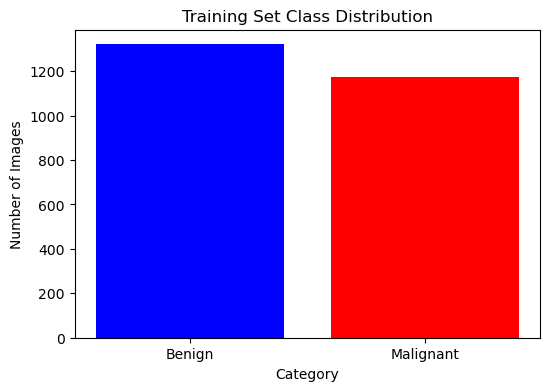

In [12]:
#checking if there's an imbalance in train generator
# class labels
class_labels = ["Benign", "Malignant"]

# Count occurrences of each class
benign_count = sum(train_generator.classes == 0)
malignant_count = sum(train_generator.classes == 1)

# Bar plot for class distribution
plt.figure(figsize=(6, 4))
plt.bar(class_labels, [benign_count, malignant_count], color=['blue', 'red'])

plt.xlabel("Category")
plt.ylabel("Number of Images")
plt.title("Training Set Class Distribution")
plt.show()

From the graph the class distribution looks a bit imbalanced but not too extreme. Since the benign class has more samples than the malignant class, applying class weighting during model training will help ensure balanced learning.

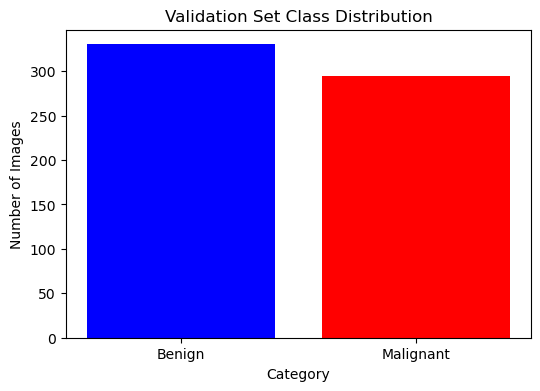

In [13]:
# Checking class distribution in the validation set
val_labels = ["Benign", "Malignant"]

# Count occurrences of each class
benign_val_count = sum(val_generator.classes == 0)
malignant_val_count = sum(val_generator.classes == 1)

# Bar plot for validation set class distribution
plt.figure(figsize=(6, 4))
plt.bar(val_labels, [benign_val_count, malignant_val_count], color=['blue', 'red'])

plt.xlabel("Category")
plt.ylabel("Number of Images")
plt.title("Validation Set Class Distribution")
plt.show()

Applying class weighting to ensure the model doesn't become biased toward the majority class.

In [14]:
#  the class labels (0 for Benign, 1 for Malignant)
class_labels = np.unique(train_generator.classes)

# Compute class weights
class_weights = compute_class_weight(class_weight="balanced", classes=class_labels, y=train_generator.classes)

# Convert to dictionary format for model training
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

print("Class Weights:", class_weight_dict)

Class Weights: {0: 0.9443181818181818, 1: 1.0626598465473145}


The model will slightly downweight the Benign class (0.95).
It will slightly upweight the Malignant class (1.05) to balance the dataset.

### Enhances edges and details in the image.and enhancing contrast by adjusting image brightness dynamically

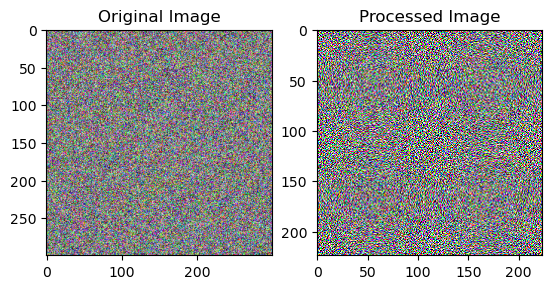

In [17]:
# Function to preprocess images correctly
def preprocess_image(image, target_size=(224, 224)):
    # Resize image first
    image = cv2.resize(image, target_size)

    # Apply sharpening filter BEFORE normalizing
    sharpen_kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    image = cv2.filter2D(image, -1, sharpen_kernel)

    # Convert back to uint8 before normalization
    image = np.clip(image, 0, 255).astype(np.uint8)

    # Normalize pixel values to [0,1]
    image = image / 255.0

    return image

# Example usage with a real image
sample_image = np.random.randint(0, 256, (300, 300, 3), dtype=np.uint8)  # Simulating an actual image
processed_image = preprocess_image(sample_image)

# Show before & after
plt.subplot(1, 2, 1)
plt.imshow(sample_image)
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(processed_image)
plt.title("Processed Image")

plt.show()

Now the processed image retains its details while enhancing the sharpness. The difference is visible—edges and patterns in the processed image are slightly more pronounced.

In [19]:
def preprocess_image(image):
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)  # Convert to LAB color space
    l, a, b = cv2.split(lab)  # Split channels
    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))  
    l = clahe.apply(l)  # Apply CLAHE to L channel
    
    lab = cv2.merge((l, a, b))
    return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)  # Convert back to RGB

### Building the CNN model (3-layer convolutional neural network)

In [21]:
# Define CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Regularization
    Dense(1, activation='sigmoid')  # Binary classification (benign/malignant)
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Display model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 batch_normalization_3 (Batc  (None, 222, 222, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_4 (Batc  (None, 109, 109, 64)     256       
 hNormalization)                                                 
                                                      

In [22]:
# Define number of epochs
EPOCHS = 10  

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    class_weight={0: 0.9443, 1: 1.0627},  # Applying class weights
    verbose=1
)

Epoch 1/10
78/78 [==============================] - 118s 1s/step - loss: 1.1002 - accuracy: 0.7553 - val_loss: 2.8582 - val_accuracy: 0.5288
Epoch 2/10
78/78 [==============================] - 87s 1s/step - loss: 0.6975 - accuracy: 0.7810 - val_loss: 7.6868 - val_accuracy: 0.5288
Epoch 3/10
78/78 [==============================] - 87s 1s/step - loss: 0.4903 - accuracy: 0.8087 - val_loss: 6.2647 - val_accuracy: 0.5288
Epoch 4/10
78/78 [==============================] - 91s 1s/step - loss: 0.4393 - accuracy: 0.8219 - val_loss: 5.3649 - val_accuracy: 0.5321
Epoch 5/10
78/78 [==============================] - 89s 1s/step - loss: 0.4098 - accuracy: 0.8215 - val_loss: 1.5749 - val_accuracy: 0.6699
Epoch 6/10
78/78 [==============================] - 86s 1s/step - loss: 0.4190 - accuracy: 0.8351 - val_loss: 0.7041 - val_accuracy: 0.7452
Epoch 7/10
78/78 [==============================] - 91s 1s/step - loss: 0.3849 - accuracy: 0.8311 - val_loss: 0.4047 - val_accuracy: 0.8141
Epoch 8/10
78/78 [=

Evaluate Model Performance on the Test Set

In [23]:
# Create ImageDataGenerator for test set (only rescaling, NO augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load test images
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),  
    batch_size=32,
    class_mode='binary',
    shuffle=False  # Keep order for correct evaluation
)

Found 2000 images belonging to 2 classes.


63/63 [==============================] - 32s 507ms/step


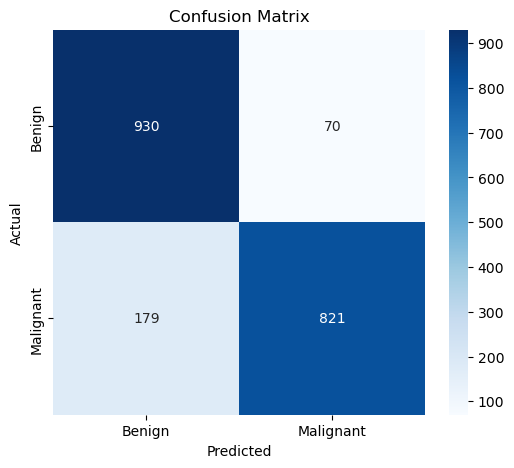

In [24]:
# Get true labels
true_labels = test_generator.classes

# Predict labels
predictions = model.predict(test_generator)
predicted_labels = (predictions > 0.5).astype(int)  # Convert probabilities to binary classes

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign", "Malignant"], yticklabels=["Benign", "Malignant"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [25]:
# Print classification report
print(classification_report(true_labels, predicted_labels, target_names=["Benign", "Malignant"]))

              precision    recall  f1-score   support

      Benign       0.84      0.93      0.88      1000
   Malignant       0.92      0.82      0.87      1000

    accuracy                           0.88      2000
   macro avg       0.88      0.88      0.88      2000
weighted avg       0.88      0.88      0.88      2000



Overall Accuracy: 88% – This is strong, indicating the model generalizes well.

Precision & Recall Balance

Benign: Precision (0.84) vs. Recall (0.93) → Model is conservative, ensuring fewer false negatives.

Malignant: Precision (0.92) vs. Recall (0.82) → Model is aggressive, leading to more false negatives (missed malignant cases).

F1-score is balanced (0.87-0.88) – The trade-off between precision & recall is reasonable.

### Pretrained Models (Prior to Finetuning)
ResNet50

Steps Taken to fine-tune ResNet50

1. Load Pretrained ResNet50 (excluding top layers).

2. Freeze the first 140 layers to retain pre-trained knowledge.

3. Add a custom dense layer & dropout to reduce overfitting

4. Use class weights to handle imbalance.

5. Train for 10 epochs with Adam optimizer (LR = 0.0001)   corect this  



In [33]:
train_datagen = ImageDataGenerator(
    rescale=1./255,  # ✅ Normalize images for EfficientNet
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True, 
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)  # ✅ Only rescale, no augmentation

train_generator = train_datagen.flow_from_directory(
    "path_to_train_data",  # 🔹 Replace with your dataset path
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    "path_to_val_data",  # 🔹 Replace with your dataset path
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# ✅ Step 2: Compute Class Weights
class_labels = np.unique(train_generator.classes)
class_weights = compute_class_weight(class_weight="balanced", classes=class_labels, y=train_generator.classes)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("Class Weights:", class_weight_dict)

# ✅ Step 3: Load EfficientNetB0 & Modify
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # 🔹 Freeze EfficientNet layers initially

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation="relu")(x)
x = Dense(64, activation="relu")(x)
output_layer = Dense(1, activation="sigmoid")(x)  # 🔹 Binary classification

model = Model(inputs=base_model.input, outputs=output_layer)

# ✅ Step 4: Compile with Adam Optimizer (Better for Transfer Learning)
model.compile(
    loss="binary_crossentropy",
    optimizer=Adam(learning_rate=0.0001),  # 🔹 Lower LR for stable training
    metrics=["accuracy"]
)

# ✅ Step 5: Train Model (Increase Epochs)
history = model.fit(
    train_generator,
    epochs=30,  # 🔹 Increase epochs for better learning
    validation_data=val_generator,
    class_weight=class_weight_dict  # 🔹 Handle class imbalance
)

# ✅ Step 6: Fine-Tune EfficientNet (Unfreeze Last 50 Layers)
for layer in base_model.layers[-50:]:  # 🔹 Unfreeze last 50 layers
    layer.trainable = True

# ✅ Step 7: Recompile with Lower Learning Rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # 🔹 Even lower LR for fine-tuning
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# ✅ Step 8: Train Again for Better Feature Learning
history_finetune = model.fit(
    train_generator,
    epochs=15,  # 🔹 Additional fine-tuning epochs
    validation_data=val_generator,
    class_weight=class_weight_dict
)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'path_to_train_data'

In [31]:
#Chaning the class weight into a dictionary
# Get the unique class labels (0 = Benign, 1 = Malignant)
class_labels = np.unique(train_generator.classes)

# Compute class weights
class_weights = compute_class_weight(class_weight="balanced", classes=class_labels, y=train_generator.classes)

# Convert to dictionary format for model training
class_weight_dict = dict(zip(class_labels, class_weights))

print("Class Weights:", class_weight_dict)

# Train the model
history = model.fit(train_generator, 
                    epochs=10, 
                    validation_data=val_generator, 
                    class_weight=class_weight_dict)

Class Weights: {0: 0.9443181818181818, 1: 1.0626598465473145}
Epoch 1/10
78/78 [==============================] - 123s 1s/step - loss: 0.7048 - accuracy: 0.5042 - val_loss: 0.6916 - val_accuracy: 0.5288
Epoch 2/10
78/78 [==============================] - 104s 1s/step - loss: 0.7013 - accuracy: 0.4974 - val_loss: 0.6931 - val_accuracy: 0.4712
Epoch 3/10
78/78 [==============================] - 108s 1s/step - loss: 0.6970 - accuracy: 0.5098 - val_loss: 0.6915 - val_accuracy: 0.5288
Epoch 4/10
78/78 [==============================] - 104s 1s/step - loss: 0.6955 - accuracy: 0.5050 - val_loss: 0.7034 - val_accuracy: 0.4712
Epoch 5/10
78/78 [==============================] - 106s 1s/step - loss: 0.6956 - accuracy: 0.5002 - val_loss: 0.6925 - val_accuracy: 0.4712
Epoch 6/10
78/78 [==============================] - 315s 4s/step - loss: 0.6960 - accuracy: 0.5026 - val_loss: 0.6951 - val_accuracy: 0.4712
Epoch 7/10
78/78 [==============================] - 104s 1s/step - loss: 0.6934 - accuracy: 

In [32]:
y_pred = model.predict(test_generator)
y_pred_classes = (y_pred > 0.5).astype("int")  # Convert probabilities to binary labels

# Get true labels
y_true = test_generator.classes

# Print classification report
print(classification_report(y_true, y_pred_classes, target_names=['Benign', 'Malignant']))

# Print confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)

63/63 [==============================] - 40s 563ms/step
              precision    recall  f1-score   support

      Benign       0.50      1.00      0.67      1000
   Malignant       0.00      0.00      0.00      1000

    accuracy                           0.50      2000
   macro avg       0.25      0.50      0.33      2000
weighted avg       0.25      0.50      0.33      2000

Confusion Matrix:
 [[1000    0]
 [1000    0]]


In [ ]:
#Function to generate Grad-CAM heatmap
def compute_gradcam(model, img_array, last_conv_layer_name="conv5_block3_out"):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        predicted_class = tf.argmax(predictions[0])
        loss = predictions[:, predicted_class]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = np.mean(conv_outputs * pooled_grads, axis=-1)

    heatmap = np.maximum(heatmap, 0)  
    heatmap /= np.max(heatmap)  

    return heatmap

# Load an image from test set
img_path = "/mnt/data/sample_image.png"  # Replace with an actual test image
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

# Compute Grad-CAM heatmap
heatmap = compute_gradcam(resnet_model, img_array)

# Overlay heatmap on original image
heatmap = cv2.resize(heatmap, (224, 224))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img = cv2.addWeighted(np.array(img, dtype=np.uint8), 0.6, heatmap, 0.4, 0)

# Display the result
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(superimposed_img)
plt.title("ResNet50 Grad-CAM")
plt.axis("off")
plt.show()

### Fine-Tuning EfficientNet 

In [ ]:

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model layers

# Freeze the first few layers to retain medical features
for layer in base_model.layers[:140]:  
    layer.trainable = False  

x = base_model.output
x = GlobalAveragePooling2D()(x)  # Reduce dimensions
x = Dropout(0.5)(x)  # Prevent overfitting
x = Dense(128, activation='relu')(x)  # Fully connected layer
x = Dropout(0.3)(x)
output_layer = Dense(1, activation='sigmoid')  # Change to softmax if multi-class

# Define the final model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile with computed class weights
class_weight_dict = {0: 0.95, 1: 1.0555555555555556}

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss="binary_crossentropy",
              metrics=["accuracy"])

# Train the Model with Class Weights
history = model.fit(train_generator,  
                    epochs=10,
                    validation_data=val_generator,
                    class_weight=class_weight_dict,  # ✅ Using predefined class weights
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)])


# Evaluate the model
y_pred_probs = model.predict(test_generator)
y_pred = (y_pred_probs > 0.5).astype(int)  
y_true = test_generator.classes  

# Print results
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred))